# Autoregressive HMM on example mouse

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
# from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from fitting_functions import cross_validate_armodel, compute_inputs
from plotting_functions import plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates


# Custom functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from one_functions_generic import prepro

one = ONE()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Parameters

In [20]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
#data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']
       var_names = ['avg_wheel_vel', 'l_paw_speed']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

List available mice

In [21]:
# Save data of all sessions for latter
idxs = []
mouse_names = []
for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    eid = design_matrices[m][14:50]
    idx = str(eid + '_' + mouse_name)
    if m == 0:
        idxs = idx
        mouse_names = mouse_name
    else:
        idxs = np.hstack((idxs, idx))
        mouse_names = np.hstack((mouse_names, mouse_name))

## Preprocess list of design matrices

- Each session is saved under the mouse name; concatenated with other sessions of the same mouse;
- Only data up to trial 90 is kept;
- Data is normalized and standardized

In [22]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mouse_name in enumerate(mouse_names):
    # Save results per mouse
    matrix_all[mouse_name] = {}
    session_all[mouse_name] = {}
    matrix_all_unnorm[mouse_name] = {}

for m, mat in enumerate(idxs):
    if len(mat) > 35: 
            
        # Trials data
        session = mat[0:36]
        mouse_name = mat[37:]
        
        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()
        session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        session_start = list(session_trials['stimOn_times'])[0]

        # Get time of last unbiased trial
        unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
        time_trial_90 = list(unbiased['stimOff_times'])[-1]
        
        filename = str('design_matrix_' + mat + '_'  + str(bin_size))  # + mouse_name + '_'
        big_design_matrix = pickle.load(open(filename, "rb"))
        design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
        design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
        design_matrix = design_matrix.dropna()
    
        # Keep only first 90 trials
        design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
        unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
        training_set = np.array(design_matrix[var_names]).copy() 
        
        if len(training_set) > 0:
            # Standardization using StandardScaler
            scaler = StandardScaler()
            standardized = scaler.fit_transform(training_set)
            # Normalize between 0 and 1
            normalizer = Normalizer().fit(standardized)
            normalized = normalizer.transform(standardized)
            
            matrix_all[mouse_name][session] = normalized
            session_all[mouse_name][session] = unbiased_trials    
            matrix_all_unnorm[mouse_name][session] = design_matrix
            
        else:
            print(session)
    else:
        print(mat)

local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.60k/4.60k [00:00<00:00, 13.5kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.26k/5.26k [00:00<00:00, 15.0kB/s]


_
poch_DY_013.png_


local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 14.3kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.38k/4.38k [00:00<00:00, 12.3kB/s]


lls_
_
poch_CSHL060.png_
_matrix_


local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.38k/5.38k [00:00<00:00, 16.7kB/s]


1b61b7f2-a599-4e40-abd6-3e758d2c9e25
_


### Collapse sessions from the same mouse

In [25]:
collapsed_matrices = defaultdict(list)
collapsed_unnorm = defaultdict(list)
collapsed_trials = defaultdict(list)

# Collapse multiple sessions per mouse
for mouse in np.unique(mouse_names):
    if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
        mouse_sessions = list(matrix_all[mouse].keys())
        for s, session in enumerate(mouse_sessions):
            collapsed_matrices[mouse] = np.vstack(matrix_all[mouse][session])
            collapsed_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse][session])
            collapsed_trials[mouse] = pd.concat(session_all[mouse], ignore_index=True)


## Parameters

In [26]:
num_iters = 100
num_train_batches = 5
method = 'kmeans'
stickiness = 5000
threshold = 0.05

# Plotting params
bin_size = 0.1
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

In [27]:
def traces_over_sates (init, design_matrix, most_likely_states, session_trials, columns_to_standardize):
    # Compute the most likely states

    end = init + 200

    fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(15, 8))

    use_data = design_matrix.copy()

    # Standardization using StandardScaler
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(use_data[columns_to_standardize])
    df_standardized = pd.DataFrame(standardized_data, columns=columns_to_standardize)

    # Normalization using MinMaxScaler
    min_max_scaler = MinMaxScaler()
    normalized_data = min_max_scaler.fit_transform(df_standardized)
    df_normalized = pd.DataFrame(normalized_data, columns=columns_to_standardize)


    df_normalized = design_matrix
    df_normalized['Bin'] = design_matrix['Bin']

    shw = axs[0].imshow(
        most_likely_states[None,:], 
        extent=(0, len(most_likely_states), -1, 1),
        aspect="auto",
        cmap='viridis',
        alpha=0.3) 

    axs[0].vlines(np.array(session_trials['goCueTrigger_times'] * 10),-1, 1, label='Stim On', color='Black', linewidth=2)
    axs[0].vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 10), -1, 1, label='Correct', color='Green', linewidth=2)
    axs[0].vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 10), -1, 1, label='Incorrect', color='Red', linewidth=2)
    axs[0].vlines(np.array(session_trials['firstMovement_times'] * 10), -1, 1, label='First movement', color='Blue')
    axs[0].vlines(np.array(session_trials['intervals_0'] * 10), -1, 1, label='Trial end', color='Grey', linewidth=2)
    axs[0].vlines(np.array((session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']) * 10), -1, 1, label='Quiescence start', color='Pink', linewidth=2)

    axs[0].hlines(0, init, end, color='Black', linestyles='dashed', linewidth=2)

    # Plot original values
    axs[0].plot(df_normalized['Bin'], df_normalized['avg_wheel_vel'], label='Wheel velocity', linewidth=2)
    axs[0].plot(df_normalized['Bin'], df_normalized['l_paw_speed'], label='WPaw speed', linewidth=2)

    axs[0].set_ylim(-1, 1)

    axs[0].set_ylabel("emissions")
    axs[0].set_xlim(init, end)
    axs[0].set_xticks(np.arange(init, end+50, 50),np.arange(init/10, end/10+5, 5))

    axs[0].set_title("inferred states")
    axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))


    plt.tight_layout()
    plt.show()
    

## Fit Autoregressive HMM

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


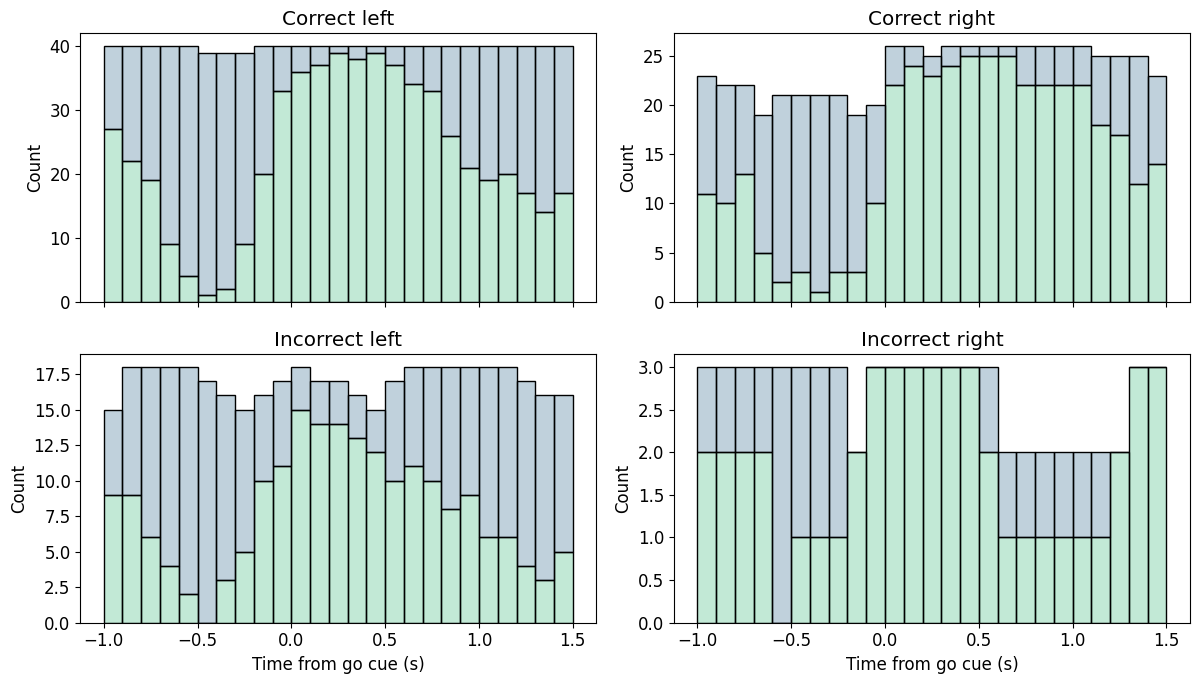

/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:293: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:295: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

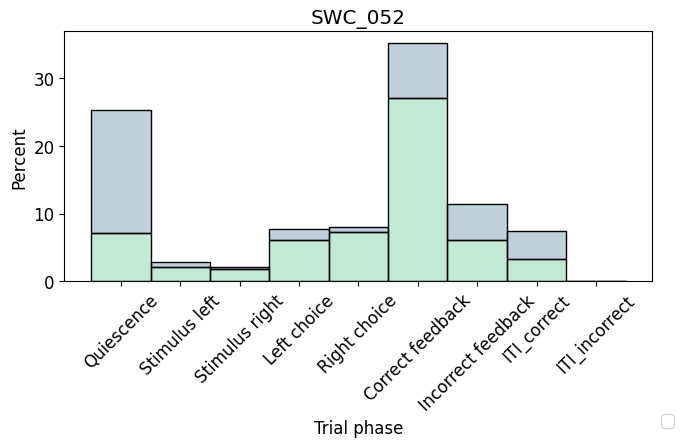

/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/axes/_base.py:2532: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


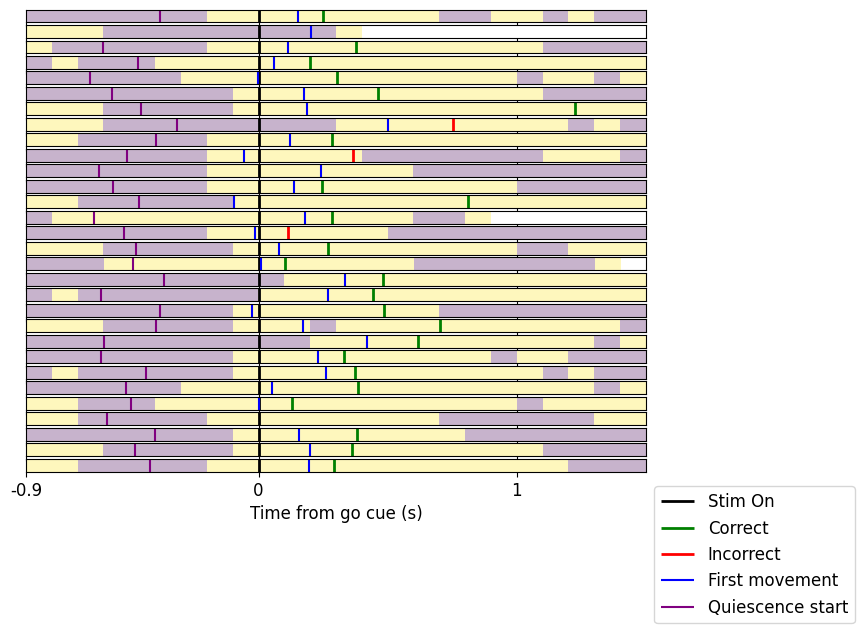

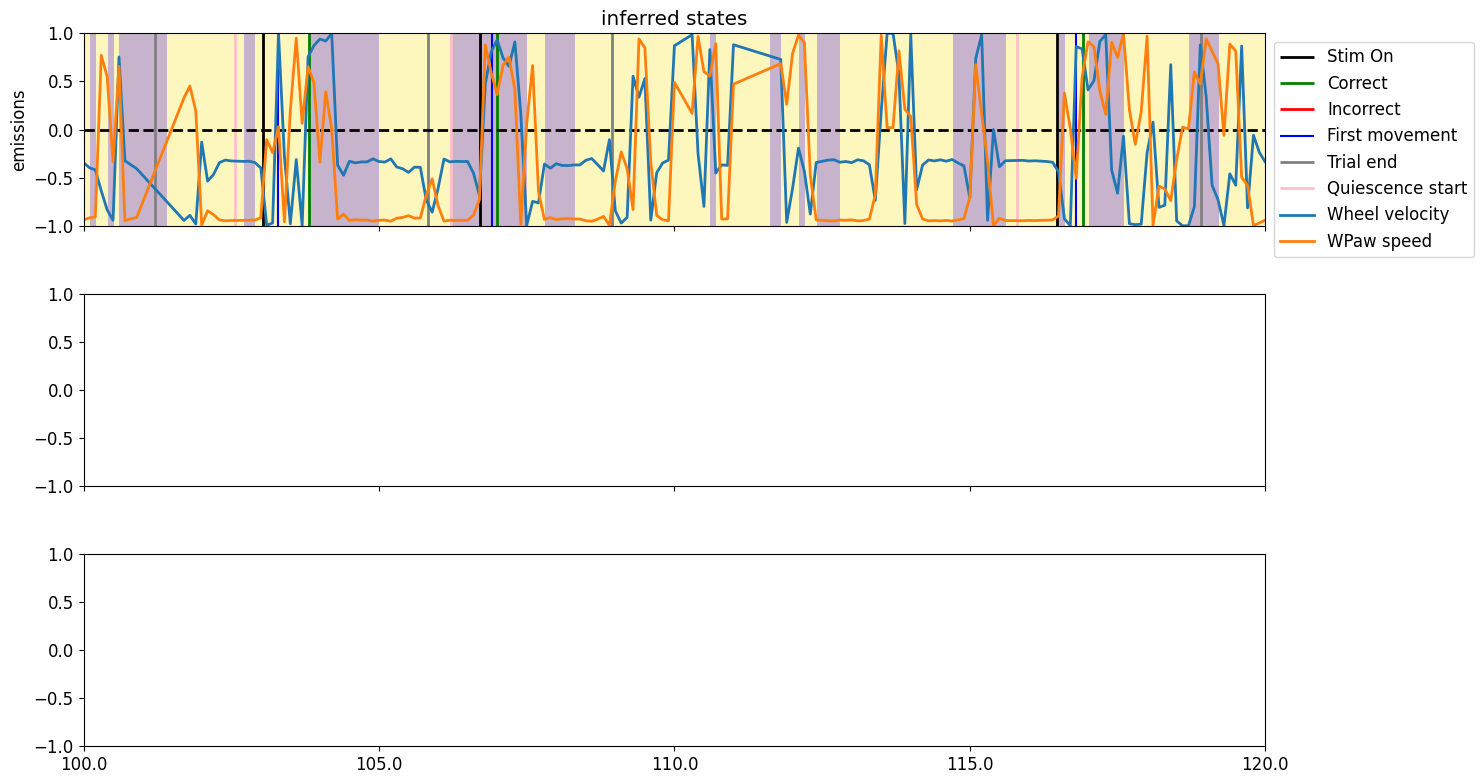

5.0


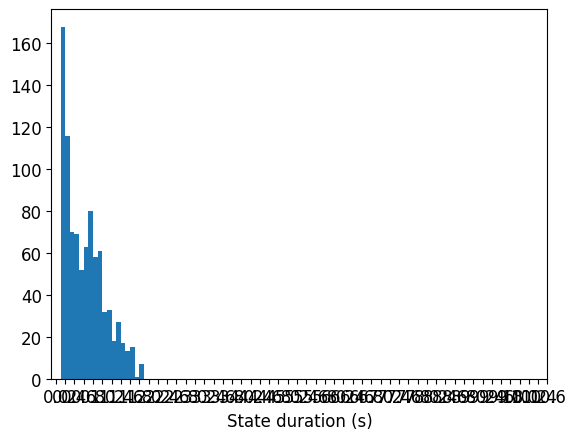

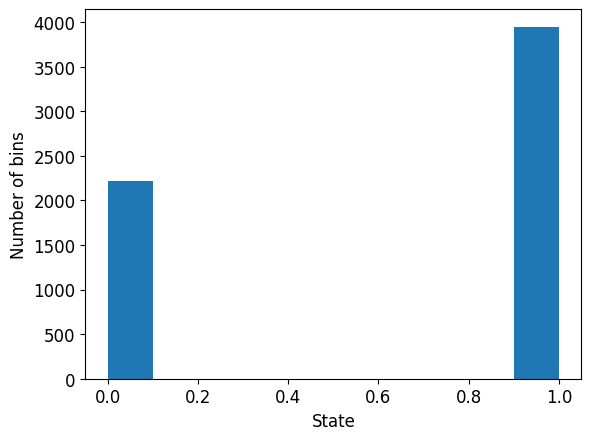

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN axis encountered
  return f_raw(*args, **kwargs)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [33]:
filename = open('best_results', 'rb')
best_fits = pickle.load(filename)

for m, mat in enumerate(idxs[0:4]):
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        # mouse_name = 'CSHL060'
        session = mat[0:36]
        
        # order = np.where(best_fits['mouse_names']==mouse_name)[0]
        # num_states = int(best_fits['best_state'][order][0])
        # num_lags = int(best_fits['best_lag'][order][0])
        num_lags = 1
        num_states = 2
        
        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]  
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
            
        " Fit model with cross-validation"
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        
        # Initialize model with Kmeans
        test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=stickiness)
        init_params, props = test_arhmm.initialize(key=jr.PRNGKey(1), method=method, emissions=shortened_array)  # for now all data
        
        # Compute inputs for required timelags
        my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
        train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
        
        # Fit model to all data with cross-validation
        val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, 
                                                                              jr.PRNGKey(0), shortened_array, train_emissions, train_inputs, method, num_train_batches)


        " Re-fit with parameters of best fold "
        # Find best fold
        use_fold = np.where(val_lls==np.nanmax(val_lls))[0][0]
        print(use_fold)
        
        # Find parameters for best fold
        initial_probs = fit_params[0].probs[use_fold]
        transition_matrix = fit_params[1].transition_matrix[use_fold]
        emission_weights = fit_params[2].weights[use_fold]
        emission_biases = fit_params[2].biases[use_fold]
        emission_covariances = fit_params[2].covs[use_fold]        
        
        # Initialize new hmm
        new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
        best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,               
                                        emission_weights=emission_weights,
                                        emission_biases=emission_biases, 
                                        emission_covariances=emission_covariances,
                                        emissions=shortened_array)  # not sure if I need to include  
        
        # Get state estimates for validation data
        most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

        # Keep only enough states to explain 95% observations
        
        unique, counts = np.unique(most_likely_states, return_counts=True)
        threshold_count = threshold * len(most_likely_states)
        excluded_bins = 0
        remaining_states = list(counts.copy())
        for state in unique:
            size_smallest_state = np.nanmin(remaining_states)
            if size_smallest_state + excluded_bins < threshold_count:
                remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                excluded_bins += size_smallest_state
        
        # Remove states below threshold
        new_states = np.array(most_likely_states).astype(float)
        exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
        # Create a boolean mask to identify values to replace
        mask = np.isin(new_states, exclude_states)
        # Replace values in main_array with np.nan using the boolean mask
        new_states[mask] = np.nan

        new_states = most_likely_states
        
        " Plots "
        # Prepare data
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
        bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
        design_matrix_heading['Bin'] = bins
        init = -10
        end = 15
        empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, new_states, multiplier)

        " Plot states stacked and aligned per trial type "
        plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
        
        """ Plot states per trial epoch """
        colors = sns.color_palette("viridis", num_states)
        states_trial = states_per_trial_phase(empirical_data, session_trials)
        plt.figure(figsize=[7, 5])
        sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
                            multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
        plt.xlabel('Trial phase')
        plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.title(mouse_name)
        plt.show()
    
        """ Stack trial states """
        trial_init = 10  # First trial to plot
        trials_to_plot = 30  # How many trials to plot (if very different will compromise readibility)
        plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, num_states)
        
        """ Plot raw traces over states """
        init = 1000 # First bin
        traces_over_sates(init, empirical_data, new_states, session_trials, var_names)
        
        
        # plt.imshow(np.mean(fit_params[1].transition_matrix, axis=0), vmin=0, vmax=1, cmap="Greys")
        # plt.xlabel("next state")
        # plt.ylabel("current state")
        # plt.title("transition matrix")
        # plt.colorbar()
        
        " Plot state durations "
        dif = np.diff(most_likely_states)
        jump = np.where(dif != 0)
        jump_dif = np.diff(jump)
        print(np.nanmedian(jump_dif))
        bins = np.arange(0, 20, 1)
        plt.hist(jump_dif[0], bins)
        plt.xticks(np.arange(0, np.max(jump_dif[0]), 2), np.arange(0, np.max(jump_dif[0]), 2)/10)
        # plt.xlim([0, 20])
        plt.xlabel('State duration (s)')
        plt.show()
        
        " Plot state frequency "
        bins = np.arange(0, num_states, 1)
        plt.hist(most_likely_states)
        plt.xlabel('State')
        plt.ylabel('Number of bins')
        # plt.xticks(np.arange(0, num_states, 1), np.arange(0, num_states, 1))
        #plt.title(ses)
        plt.show()

In [34]:
val_lls

Array([nan, nan, nan, nan, nan], dtype=float32)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


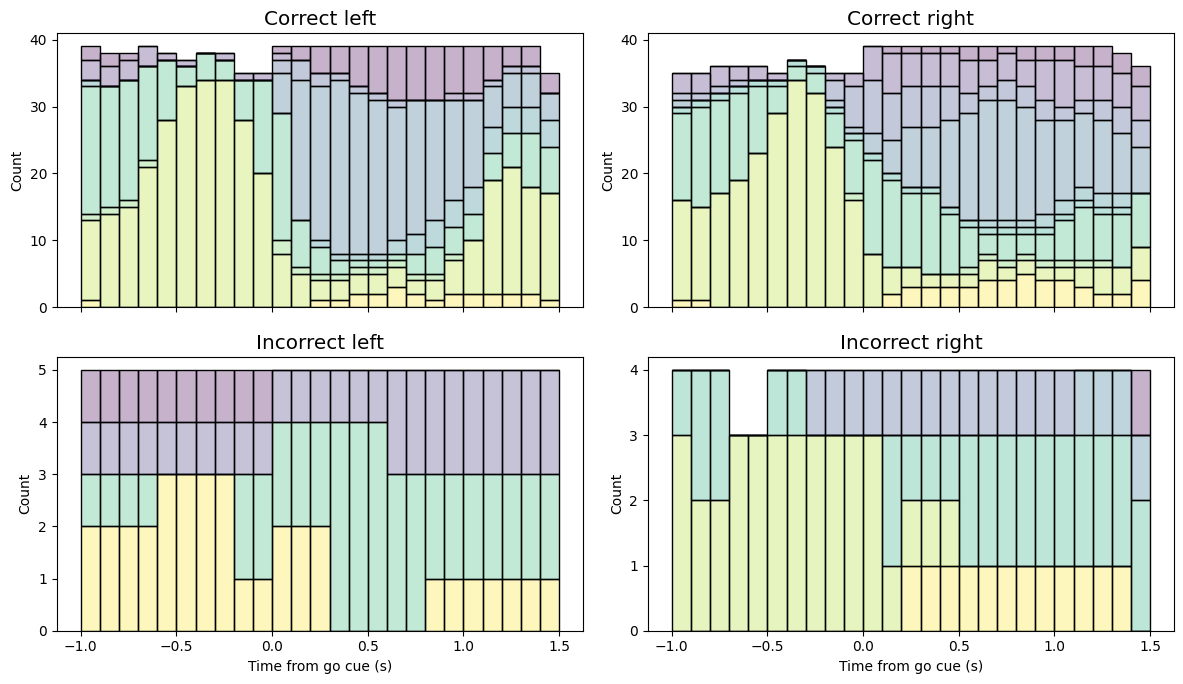

KeyError: 'quiescencePeriod'

In [6]:
# TODO: need to adjust based on cell above

filename = open('best_results', 'rb')
best_fits = pickle.load(filename)

# Loop through mice
for m, mouse_name in enumerate(np.unique(mouse_names)[0:2]):
    if len(mouse_name) > 0:
        
        order = np.where(best_fits['mouse_names']==mouse_name)[0]
        num_states = int(best_fits['best_state'][order][0])
        num_lags = int(best_fits['best_lag'][order][0])
        num_lags = 2
        
        # Get mouse data
        session_trials = session_all[mouse_name]
        design_matrix = matrix_all[mouse_name]
        unnorm_mat = matrix_all_unnorm[mouse_name]  
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
            
        " Fit model with cross-validation"
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        
        # Initialize model with Kmeans
        test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=stickiness)
        init_params, props = test_arhmm.initialize(key=jr.PRNGKey(1), method=method, emissions=shortened_array)  # for now all data
        
        # Compute inputs for required timelags
        my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
        train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
        
        # Fit model to all data with cross-validation
        val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, 
                                                                              jr.PRNGKey(0), shortened_array, train_emissions, train_inputs, method, num_train_batches)

        " Re-fit with parameters of best fold "
        # Find best fold
        use_fold = np.where(val_lls==np.nanmax(val_lls))[0][0]
        print(use_fold)
        
        # Find parameters for best fold
        initial_probs = fit_params[0].probs[use_fold]
        transition_matrix = fit_params[1].transition_matrix[use_fold]
        emission_weights = fit_params[2].weights[use_fold]
        emission_biases = fit_params[2].biases[use_fold]
        emission_covariances = fit_params[2].covs[use_fold]        
        
        # Initialize new hmm
        new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
        best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,               
                                        emission_weights=emission_weights,
                                        emission_biases=emission_biases, 
                                        emission_covariances=emission_covariances,
                                        emissions=shortened_array)  # not sure if I need to include  

        # Get state estimates for validation data
        most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

        # Keep only enough states to explain 95% observations
        
        unique, counts = np.unique(most_likely_states, return_counts=True)
        threshold_count = threshold * len(most_likely_states)
        excluded_bins = 0
        remaining_states = list(counts.copy())
        for state in unique:
            size_smallest_state = np.nanmin(remaining_states)
            if size_smallest_state + excluded_bins < threshold_count:
                remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                excluded_bins += size_smallest_state
        
        # Remove states below threshold
        new_states = np.array(most_likely_states).astype(float)
        exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
        # Create a boolean mask to identify values to replace
        mask = np.isin(new_states, exclude_states)
        # Replace values in main_array with np.nan using the boolean mask
        new_states[mask] = np.nan

        new_states = most_likely_states
        
        " Plots "
        # Prepare data
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
        bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
        design_matrix_heading['Bin'] = bins
        init = -10
        end = 15
        empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, new_states, multiplier)

        " Plot states stacked and aligned per trial type "
        plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
        
        """ Plot states per trial epoch """
        colors = sns.color_palette("viridis", num_states)
        states_trial = states_per_trial_phase(empirical_data, session_trials)
        plt.figure(figsize=[7, 5])
        sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
                            multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
        plt.xlabel('Trial phase')
        plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.title(mouse_name)
        plt.show()
    
        """ Stack trial states """
        trial_init = 10  # First trial to plot
        trials_to_plot = 30  # How many trials to plot (if very different will compromise readibility)
        plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, num_states)
        
        """ Plot raw traces over states """
        init = 1000 # First bin
        traces_over_sates(init, empirical_data, new_states, session_trials, var_names)
        
        
        # plt.imshow(np.mean(fit_params[1].transition_matrix, axis=0), vmin=0, vmax=1, cmap="Greys")
        # plt.xlabel("next state")
        # plt.ylabel("current state")
        # plt.title("transition matrix")
        # plt.colorbar()
        
        " Plot state durations "
        dif = np.diff(most_likely_states)
        jump = np.where(dif != 0)
        jump_dif = np.diff(jump)
        print(np.nanmedian(jump_dif))
        bins = np.arange(0, 20, 1)
        plt.hist(jump_dif[0], bins)
        plt.xticks(np.arange(0, np.max(jump_dif[0]), 2), np.arange(0, np.max(jump_dif[0]), 2)/10)
        # plt.xlim([0, 20])
        plt.xlabel('State duration (s)')
        plt.show()
        
        " Plot state frequency "
        bins = np.arange(0, num_states, 1)
        plt.hist(most_likely_states)
        plt.xlabel('State')
        plt.ylabel('Number of bins')
        # plt.xticks(np.arange(0, num_states, 1), np.arange(0, num_states, 1))
        #plt.title(ses)
        plt.show()

        

In [310]:
use_data = empirical_data[['avg_wheel_vel', 'pupil_diameter', 'whisker_me', 'nose_speed',
       'l_paw_speed', 'left_X', 'left_Y', 'pupil_speed', 'pupil_X', 'pupil_Y',
       'Lick count', 'Bin', 'most_likely_states']]
melted = pd.melt(use_data, id_vars=['Bin', 'most_likely_states'], value_vars=var_names)

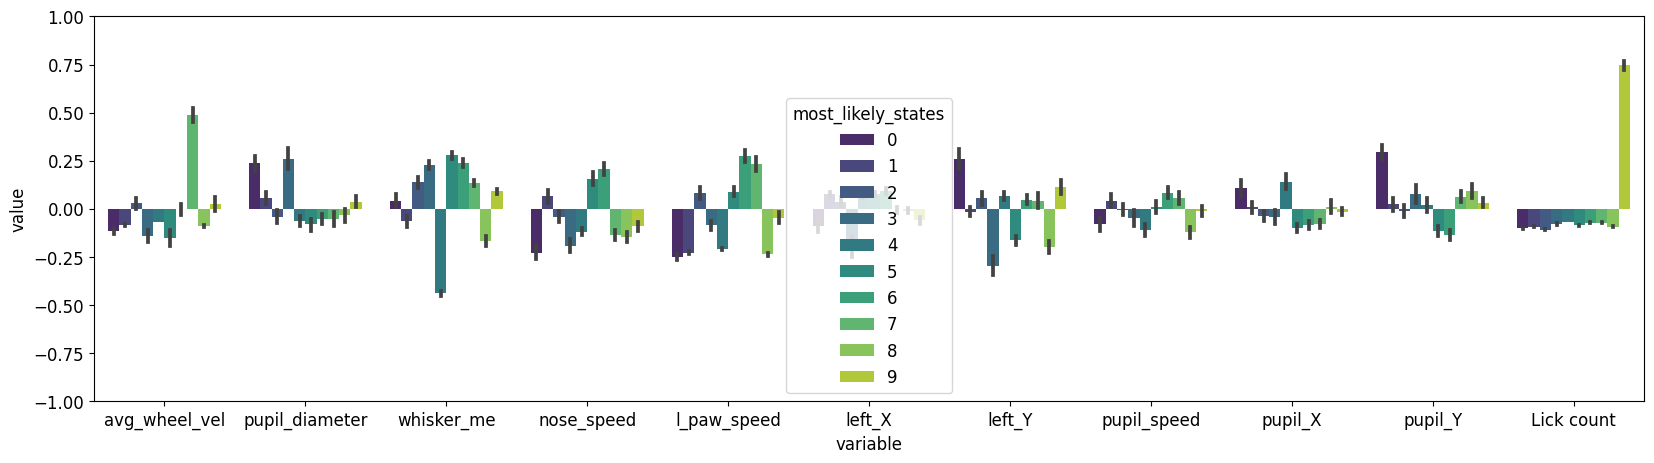

(-1.0, 1.0)

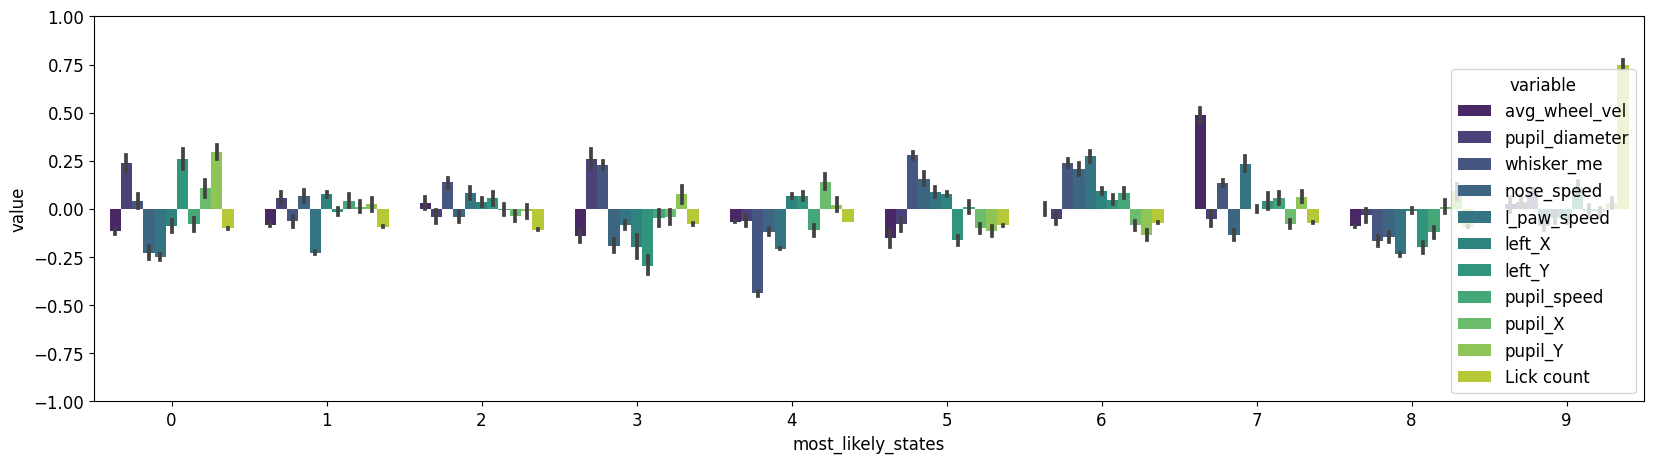

In [311]:
fig, ax = plt.subplots(figsize=[20, 5])
sns.barplot(x='variable', y='value', hue='most_likely_states', data=melted, palette='viridis')
plt.ylim([-1, 1])
plt.show()
fig, ax = plt.subplots(figsize=[20, 5])
sns.barplot(hue='variable', y='value', x='most_likely_states', data=melted, palette='viridis')
plt.ylim([-1, 1])

In [300]:
use_data.loc[use_data['variable']]
use_data['variable'].replace(['avg_wheel_vel', 'pupil_diameter', 'whisker_me', 'nose_speed',
       'l_paw_speed', 'pupil_speed', 
       'Lick count'], ['Signed wheel speed', 'Pupil diameter', 'Whisker ME', 'Nose speed',
       'Paw speed', 'Pupil speed', 
       'Lick count'])

KeyError: "None of [Index(['avg_wheel_vel', 'avg_wheel_vel', 'avg_wheel_vel', 'avg_wheel_vel',\n       'avg_wheel_vel', 'avg_wheel_vel', 'avg_wheel_vel', 'avg_wheel_vel',\n       'avg_wheel_vel', 'avg_wheel_vel',\n       ...\n       'Lick count', 'Lick count', 'Lick count', 'Lick count', 'Lick count',\n       'Lick count', 'Lick count', 'Lick count', 'Lick count', 'Lick count'],\n      dtype='object', length=1085)] are in the [index]"

In [303]:
use_data.loc[use_data['variable']=='avg_wheel_vel', 'variable'] = 'Signed wheel speed'
use_data.loc[use_data['variable']=='pupil_diameter', 'variable'] = 'Pupil diameter'
use_data.loc[use_data['variable']=='whisker_me', 'variable'] = 'Whisker ME'
use_data.loc[use_data['variable']=='nose_speed', 'variable'] = 'Nose speed'
use_data.loc[use_data['variable']=='l_paw_speed', 'variable'] = 'Paw speed'
use_data.loc[use_data['variable']=='pupil_speed', 'variable'] = 'Pupil speed'


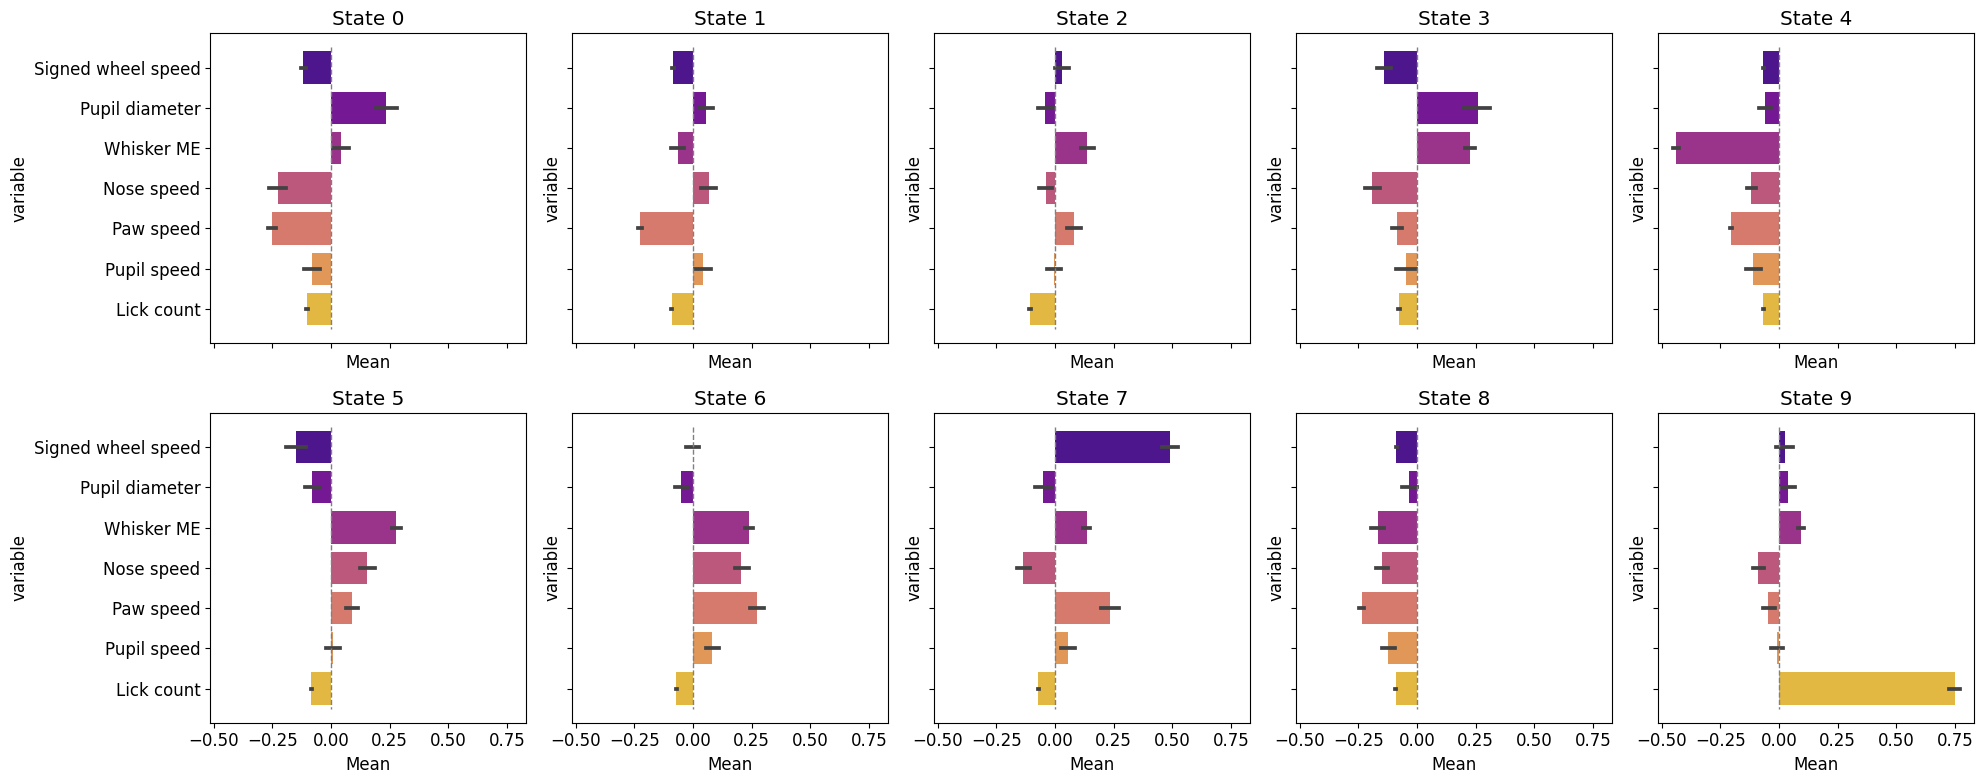

In [312]:
use_vars = ['avg_wheel_vel', 'pupil_diameter', 'whisker_me', 'nose_speed',
       'l_paw_speed', 'pupil_speed', 
       'Lick count', 'Bin', 'most_likely_states']
# var_labels = ['Signed wheel speed', 'Pupil diameter', 'Whisker ME', 'Nose speed',
#        'Paw speed', 'Pupil speed', 
#        'Lick count']
use_data = empirical_data[use_vars]

melted = pd.melt(use_data, id_vars=['Bin', 'most_likely_states'], value_vars=use_vars)

melted.loc[melted['variable']=='avg_wheel_vel', 'variable'] = 'Signed wheel speed'
melted.loc[melted['variable']=='pupil_diameter', 'variable'] = 'Pupil diameter'
melted.loc[melted['variable']=='whisker_me', 'variable'] = 'Whisker ME'
melted.loc[melted['variable']=='nose_speed', 'variable'] = 'Nose speed'
melted.loc[melted['variable']=='l_paw_speed', 'variable'] = 'Paw speed'
melted.loc[melted['variable']=='pupil_speed', 'variable'] = 'Pupil speed'

states = []
for s in range(num_states):
    state = 'State ' + str(s)
    states.append(state) 
        
fig, ax = plt.subplots(ncols=int(len(states)/2) , nrows=2, sharex=True, sharey=True, figsize=[20, 8])
plt.rc('font', size=12)

for s, state in enumerate(states):
    use_data = melted.loc[melted['most_likely_states']==s]
    if s < len(states)/2:  
        sns.barplot(y='variable', x='value', data=use_data, ax=ax[0,s], palette='plasma')
        ax[0,s].vlines(0, -.50, 6.5, color='Gray', linestyles='--', linewidth=1)
        ax[0,s].set_xlabel('Mean')
        ax[0,s].set_title(state)
    else:
        sns.barplot(y='variable', x='value', data=use_data, ax=ax[1,s-5], palette='plasma')
        ax[1,s-5].vlines(0, -.50, 6.5, color='Gray', linestyles='--', linewidth=1)
        ax[1,s-5].set_xlabel('Mean')
        ax[1,s-5].set_title(state)

plt.tight_layout()
plt.show()
    

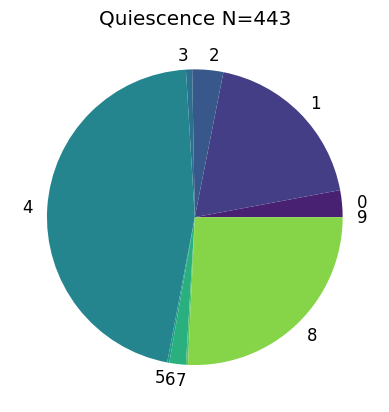

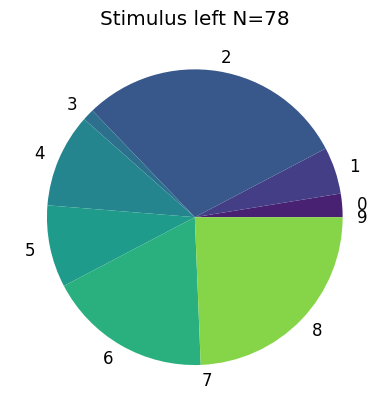

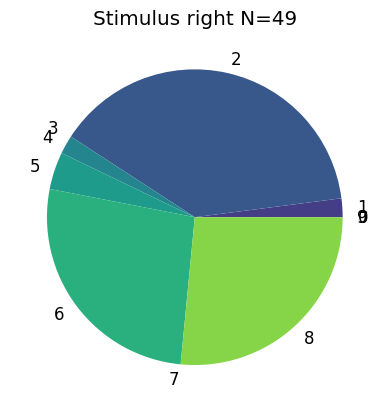

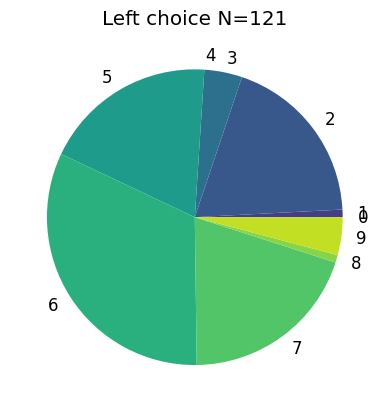

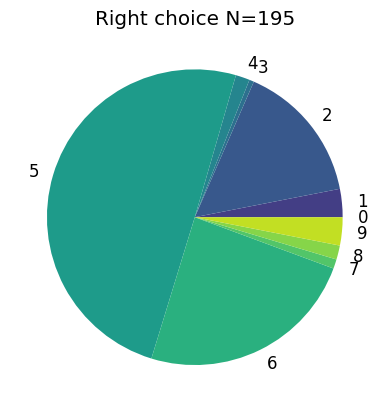

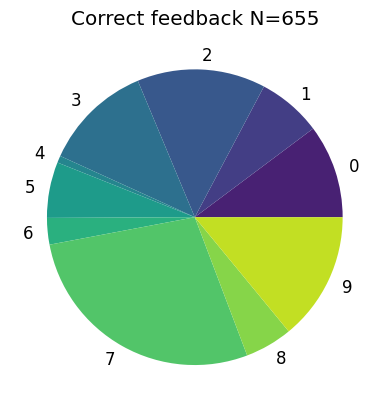

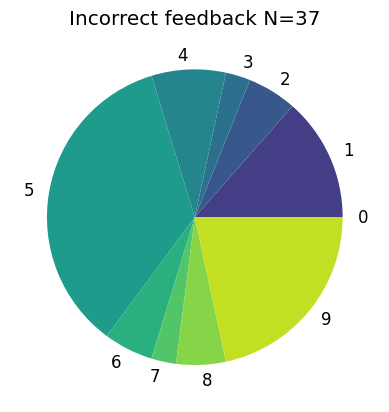

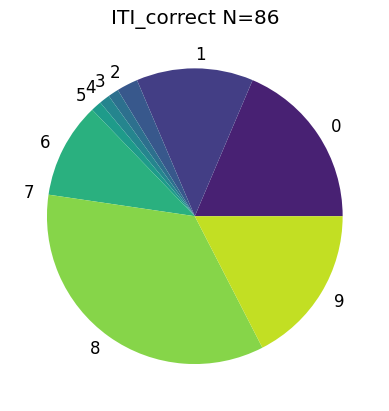

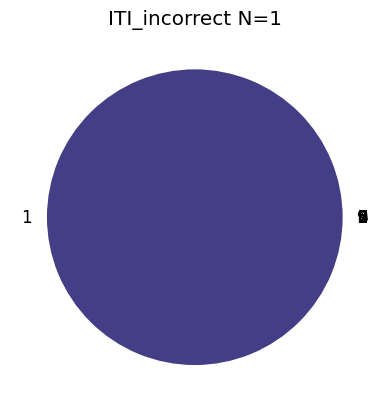

In [313]:
palette_color = sns.color_palette('viridis', n_colors=num_states)
epochs = states_trial['label'].unique()

st = np.unique(most_likely_states)

for epoch in epochs:
    all_counts = np.zeros(len(st))
    unique, counts = np.unique(states_trial.loc[states_trial['label']==epoch, 0], return_counts=True)
    all_counts[unique.astype(int)] = counts
    plt.pie(all_counts, labels=st,  colors=palette_color)  # , labels=keys
    plt.title(str(epoch + ' N=' + str(int(sum(all_counts))) ))
    plt.show()

In [7]:
    # def traces_over_sates (init, design_matrix, most_likely_states, session_trials, columns_to_standardize):
    init = 1500
    design_matrix = empirical_data
    posteriors = posterior.smoothed_probs
    columns_to_standardize = var_names
    
    # Compute the most likely states

    end = init + 200

    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 5))

    use_data = design_matrix.copy()

    # Standardization using StandardScaler
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(use_data[columns_to_standardize])
    df_standardized = pd.DataFrame(standardized_data, columns=columns_to_standardize)

    # Normalization using MinMaxScaler
    min_max_scaler = MinMaxScaler()
    normalized_data = min_max_scaler.fit_transform(df_standardized)
    df_normalized = pd.DataFrame(normalized_data, columns=columns_to_standardize)

    df_normalized['Bin'] = design_matrix['Bin']

    shw = axs.imshow(
        most_likely_states[None,:], 
        extent=(0, len(most_likely_states), 0, 1),
        aspect="auto",
        cmap='viridis',
        alpha=0.3) 

    axs.vlines(np.array(session_trials['goCueTrigger_times'] * 10),0, 1, label='Stim On', color='Black', linewidth=2)
    axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 10), 0, 1, label='Correct', color='Green', linewidth=2)
    axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 10), 0, 1, label='Incorrect', color='Red', linewidth=2)
    axs.vlines(np.array(session_trials['firstMovement_times'] * 10), 0, 1, label='First movement', color='Blue')
    axs.vlines(np.array(session_trials['intervals_0'] * 10), 0, 1, label='Trial end', color='Grey', linewidth=2)
    axs.vlines(np.array((session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']) * 10), 0, 1, label='Quiescence start', color='Pink', linewidth=2)

    # axs.hlines(0, init, end, color='Black', linestyles='dashed', linewidth=2)

    # # Plot original values
    # for s, state in enumerate(range(num_states)):
    #     axs.plot(posteriors[:, s], label=str('State ' + str(s)), linewidth=1, linestyle='dashed', color=colors[s])

    axs.set_ylim(-0.05, 1.05)

    axs.set_ylabel("emissions")
    axs.set_xlabel("time (s)")
    axs.set_xlim(init, end)
    axs.set_xticks(np.arange(init, end+50, 50),np.arange(init/10, end/10+5, 5))

    axs.set_title("inferred states")
    axs.legend(loc='upper left', bbox_to_anchor=(1, 1))


    plt.tight_layout()
    plt.show()
    

NameError: name 'posterior' is not defined

In [24]:
print(type(session_trials))
print(type(empirical_data))
print(type(list(most_likely_states)))
print(type(design_matrix_heading))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'list'>
<class 'pandas.core.frame.DataFrame'>


In [25]:
save_data = defaultdict(list)
save_data['session_trials'] = []
save_data['session_trials'] = session_trials
save_data['empirical_data'] = []
save_data['empirical_data'] = empirical_data
save_data['most_likely_states'] = []
save_data['most_likely_states'] = most_likely_states
save_data['design_matrix_heading'] = []
save_data['design_matrix_heading'] = design_matrix_heading

In [26]:
pickle_file = open('data_CSHL060', 'wb')
pickle.dump(save_data, pickle_file)